# Well-documented and Modular Code for Each Step of the Process

This notebook covers the following steps:

1. **Data Preprocessing and Transformation**:
    - Extract offerings and destinations from the tags column using the provided mapping file.
    - Generate new columns from the ratings column to represent actual user ratings.
    - Derive a sentiment column using a sentiment analysis method to categorise reviews as positive, neutral, or negative.
    
2. **Text Cleaning and NLP Analysis**:
    - Apply NLP techniques to clean the review text (removing stop words, stemming, etc.).
    - Conduct text analysis to identify common keywords and derive potential categories/themes discussed in the reviews.
    
3. **Exploratory Data Analysis (EDA)**:
    - Analyze the distribution of sentiments, offerings, destinations, and ratings.
    - Investigate patterns or correlations between different variables (e.g., relation between sentiment and ratings).


## Install and import needed libraries

In [1]:
!pip install -r requirements.txt
import pandas as pd
import json
import ast
import seaborn as sns
from transformers import pipeline
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

c:\Users\alikh\anaconda3\envs\tf_new\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


## Load the CSV and json files

In [2]:
dataset_path = 'dataset.csv_(DS_A-L2).csv'
df = pd.read_csv(dataset_path)

# Load the JSON mapping file
mapping_path = 'mappings.json_(DS_A-L2).json'
with open(mapping_path, 'r') as f:
    mappings = json.load(f)


# 1. **Data Preprocessing and Transformation**


## Extract offerings and destinations from the tags column using the provided mapping file.


### Define functions to extract offerings and destinations from tags


In [3]:
# Extract mappings
tags_mapping = mappings['tags_mapping']

# Define functions to extract offerings and destinations from tags
def get_offerings(tags):
    offerings = []
    for tag in tags:
        tag_value = tag.get('value')
        if tag_value in tags_mapping:
            offerings.append(tags_mapping[tag_value][0])
    return offerings if offerings else None

def get_destinations(tags):
    destinations = []
    for tag in tags:
        tag_value = tag.get('value')
        if tag_value in tags_mapping:
            destinations.append(tags_mapping[tag_value][1])
    return destinations if destinations else None

# Convert the 'tags' column from string representation to a list of dictionaries
df['tags'] = df['tags'].apply(eval)

# Apply functions to create new columns
df['offerings'] = df['tags'].apply(get_offerings)
df['destinations'] = df['tags'].apply(get_destinations)

## Generate new columns from the ratings column to represent actual user ratings.

Two new columns would be derived from the ratings column to represent actual user ratings, one for the normalized ratings `norm_user_rating` and another for the original ratings `user_rating`

In [4]:
# Function to parse ratings column
def parse_ratings(rating_str):
    if pd.isna(rating_str):
        return {}
    rating_dict = ast.literal_eval(rating_str)
    return rating_dict

# Apply parsing function to ratings column
rating_columns = df['ratings'].apply(parse_ratings)
rating_df = pd.DataFrame(rating_columns.tolist())

# Rename the columns to user_rating and norm_user_rating
rating_df.rename(columns={'raw': 'user_rating', 'normalized': 'norm_user_rating'}, inplace=True)

# Concatenate the new ratings columns with the original dataframe
df = pd.concat([df, rating_df], axis=1)


## Derive a sentiment column using a sentiment analysis method to categorise reviews as positive, neutral, or negative



### Approach 1: Using Pre-trained Sentiment Analysis Pipeline

In this approach, a pre-trained sentiment analysis model is utilized to classify the sentiment of reviews. The model, `akhooli/xlm-r-large-arabic-sent`, was chosen for its capability to handle both Arabic and English text, including mixed-language text. It is specifically designed for sentiment analysis in both Arabic and English and is available in the transformers library. The advantages of using a pre-trained model include the ease of implementation and the ability to leverage a model that has been trained on a large dataset, enhancing its accuracy and reliability.

 By applying this model to our dataset, we can efficiently categorize reviews as positive, neutral, or negative, optimized using parallel processing to handle large datasets effectively.

 ***Note***: This cell takes approximately 40 minutes to finish.


In [5]:
# Initialize the sentiment analysis pipeline
# sentiment_pipe = pipeline("text-classification", model="PRAli22/AraBert-Arabic-Sentiment-Analysis", truncation=True)
sentiment_pipe = pipeline("text-classification", model="akhooli/xlm-r-large-arabic-sent", truncation=True) 
# Function to classify sentiment
def get_sentiment(text):
    result = sentiment_pipe(text[:512])  # Truncate text to the first 512 characters
    return result[0]['label']

# Apply the sentiment analysis to the content column with a progress bar and multiprocessing
def process_row(row):
    row['sentiment'] = get_sentiment(row['content'])
    return row

# Use ThreadPoolExecutor for parallel processing
with ThreadPoolExecutor(max_workers=4) as executor:
    results = list(tqdm(executor.map(process_row, [row for _, row in df.iterrows()]), total=len(df)))

# Convert the results back to a DataFrame
df = pd.DataFrame(results)

label_map = {'LABEL_0': 'Neutral', 'LABEL_1': 'Negative', 'LABEL_2': 'Positive'}
df['sentiment'] = df['sentiment'].map(label_map)

Some weights of the model checkpoint at akhooli/xlm-r-large-arabic-sent were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 10000/10000 [34:58<00:00,  4.77it/s] 


### Approach 2: Using a Custom Language Model for Sentiment Analysis

In this approach, a custom language model is employed for sentiment analysis. The model, `unsloth/llama-3-8b-bnb-4bit`, is based on LLaMA 3, which is proven to be highly effective for various language tasks. This model is a powerful language model capable of handling various tasks, including text generation and analysis. By creating a custom prompt that instructs the model to classify the sentiment of the reviews, we can leverage its power for sentiment analysis. This approach allows for more control over the model's behavior and can be tailored further to meet specific requirements. Although it requires more setup compared to a pre-trained pipeline, it can potentially offer more accurate and context-aware sentiment classification. Additionally, the use of 4-bit quantization helps in reducing memory usage, making the processing more efficient.


#### First, we need to install the necessary libraries. The provided code is designed for Google Colab, as it supports GPU and is compatible with Unsloth. 
#### Due to GPU limitations, this notebook will not execute the model. Instead, the notebook provides the code to run the model on the full dataset. While this notebook demonstrates the process on the full dataset, a separate run was conducted on 4000 rows. The results of that run are available in the GitHub repository (https://github.com/alikhater75/Artifact-DS_A-L2) under the filename `dataset_with_sentiment_LLM.csv`.

**Note:** Loading the model will download a file of nearly 5 GB.

In [ ]:
# # Installs Unsloth, Xformers (Flash Attention) and all other packages!
# !pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
# !pip install --no-deps xformers "trl<0.9.0" peft accelerate bitsandbytes

# from unsloth import FastLanguageModel
# import torch
# dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
# load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.


# model, tokenizer = FastLanguageModel.from_pretrained(
#     model_name = "unsloth/llama-3-8b-bnb-4bit", 
#     max_seq_length = 1,
#     dtype = dtype,
#     load_in_4bit = load_in_4bit,
# )


A prompt was crafted to maximize LLM efficiency for accurate sentiment analysis of customer reviews

In [ ]:
# # Define the function to analyze sentiment
# def analyze_sentiment(text):
#     """
#     Analyzes sentiment of the given text using an LLM model.

#     This function generates an instruction prompt to classify text as positive, negative, or neutral based on customer reviews.
#     It utilizes a tokenizer and model for analysis, processes input on CUDA-enabled devices, and extracts sentiment from the model's response.
#     """
        
#     alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

#     ### Instruction:
#     You are an expert in sentiment analysis and evaluating customer reviews. Please analyze the sentiment of the following text and classify it as positive, negative, or neutral. Only return the sentiment.

#     ### Input:
#     {}

#     ### Response:
#     {}"""

#     input_text = alpaca_prompt.format(text, "")
#     inputs = tokenizer([input_text], return_tensors="pt").to("cuda")
#     outputs = model.generate(**inputs, max_new_tokens=1, use_cache=True)
#     response = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

#     # Extract sentiment from the response
#     sentiment = response.split("### Response:\n")[1].strip()
#     return sentiment



# # Apply the sentiment analysis to each review in the dataset with a progress bar
# sentiments = []
# for content in tqdm(df['content'], desc="Analyzing Sentiment"):
#     sentiments.append(analyze_sentiment(content))

# df['sentiment'] = sentiments


#### Comparing the two approaches, and choosing the best approache is challenging due to the unlabeled data. One method is to manually label random samples and assess each approach's performance. Another method, as discussed in the EDA part, is to calculate the correlation with customer ratings.

# 2. **Text Cleaning and NLP Analysis**:


### Apply NLP techniques to clean the review text (removing stop words, stemming, etc.).

#### Text Cleaning Approaches

This section uses distinct approaches to clean and preprocess both English and Arabic text data before further analysis. The steps are as follows:

1. **Remove Special Characters and Numbers:** All non-alphabetic characters and digits are stripped out to retain only letters.
2. **Tokenization:** Text is split into individual words using the `word_tokenize` method.
3. **Stopword Removal:** Common stopwords are removed using predefined lists (NLTK for English and a arabicstopwords for Arabic).

#### Additional Steps for English Text:
1. **Stemming:** Words are reduced to their base or root form using the Snowball Stemmer from NLTK. This helps in normalizing the words to their root forms for better text analysis.

#### Additional Steps for Arabic Text:
1. **Remove English letters:** As some arabic reviews have englist text in it, the English text should be removed to provide accurate analysis for Arabic text.

#### Note on Arabic Text:
- **No Stemming:** The script does not perform stemming for Arabic text. Stemming Arabic words is more complex due to the rich morphology of the language, and it may require specialized stemming algorithms like Farasa or ISRI. Therefore, in this script, stemming is skipped to maintain simplicity and avoid potential inaccuracies.


In [6]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from collections import Counter
from arabicstopwords.arabicstopwords import stopwords_list 
import re 
from farasa.stemmer import FarasaStemmer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')



# Function to clean and stem English text
def clean_english_text(text):
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize text
    words = word_tokenize(str(text).lower())
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    stemmer = SnowballStemmer('english')

    
    return ' '.join([stemmer.stem(word) for word in words])

# Function to clean and stem Arabic text
def clean_arabic_text(text):
    # Remove English text
    text = re.sub(r'[a-zA-Z]', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^ء-ي\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    arabic_stopwords = stopwords_list()
    words = word_tokenize(str(text))
    words = [word for word in words if word not in arabic_stopwords]
    return ' '.join(words)


# Apply text cleaning based on the existing language column
df['cleaned_content'] = df.apply(lambda row: clean_english_text(row['content']) if row['language'] == 'eng' else clean_arabic_text(row['content']), axis=1)

# Separate English and Arabic reviews
english_df = df[df['language'] == 'eng']
arabic_df = df[df['language'] == 'ara']

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alikh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alikh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Conduct text analysis to identify common keywords and derive potential categories/themes discussed in the reviews.

### Identifying Common Keywords and Deriving Themes from Reviews

This analysis utilizes two main approaches to gain insights from a collection of reviews:

1. **Extracting Themes using NMF:**
   - Transform the text data into a Term Frequency - Inverse Document Frequency (TF-IDF) matrix, filtering out very common or rare terms.
   - Apply Non-negative Matrix Factorization (NMF) to the TF-IDF matrix to identify latent themes.
   - Each theme is described by the top words that contribute most to it.

2. **Extracting Common Keywords:**
   - Create a TF-IDF matrix for the text data.
   - Sort terms by their TF-IDF scores to select the top keywords.
   - The result is a list of top keywords representing the most relevant terms.
   - ***An additional Step for Arabic Text:***
      - Stemming for common Keywords For Arabic common Keywords, apply stemming to reduce words to their root forms to be in a better shape in the word cloud . 

3. **Creating Word Clouds:**
   - Generate word clouds from the top keywords to visualize the most common terms.


Analysis of English reviews:

Themes in English reviews:
Theme 1: good, hotel, famili, park, food, servic, clean, staff, room, friend
Theme 2: nice, view, place, park, hotel, famili, clean, mall, locat, coffe
Theme 3: googl, origin, moretransl, excel, god, best, restaur, price, food, delici
Theme 4: place, beauti, visit, great, famili, amaz, best, relax, enjoy, world
Theme 5: love, staff, park, locat, hotel, went, citi, baboon, alway, coffe

Top keywords in English reviews:
even, cheap, entranc, tasti, well, recommend, staff, food, clean, place, fit, fill, film, final, find, fine, fire, first, fish, five


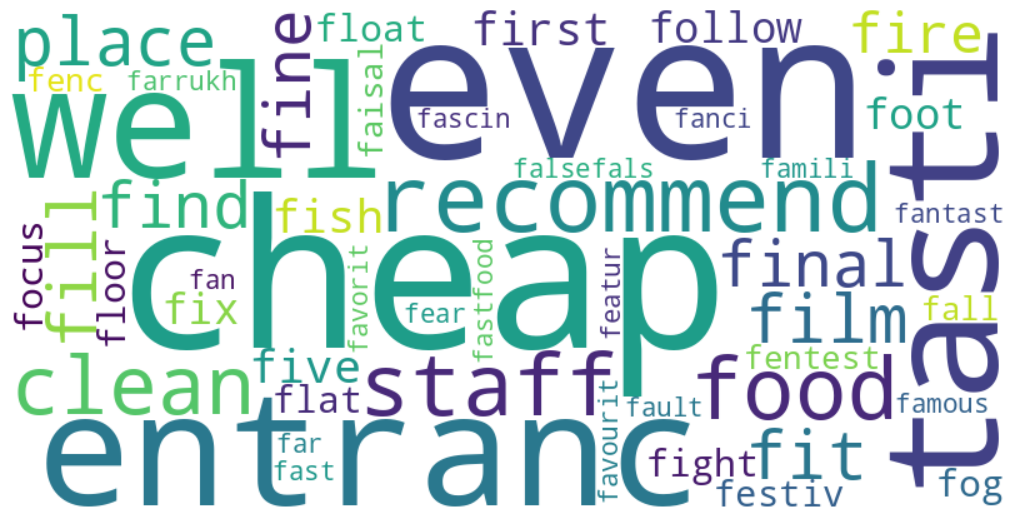



Analysis of Arabic reviews:

Themes in Arabic reviews:
Theme 1: جميل, فندق, وهادئ, ونظيف, منتزه, المكان, ورائع, الفندق, موقع, ومرتب
Theme 2: ممتاز, فندق, موقع, ونظيف, الفندق, الموقع, تعامل, نظيف, المكان, ورائع
Theme 3: رائع, اكثر, فندق, وجميل, منتزه, المكان, ونظيف, نظيف, مطعم, الفندق
Theme 4: جيد, فندق, موقع, ونظيف, يحتاج, نوعا, مطعم, الفندق, المطعم, نظيف
Theme 5: مكان, مميز, هادئ, وجميل, الزيارة, الله, يستحق, حلو, ورائع, افضل

Top keywords in Arabic reviews:
روعة, الله, فندق, قدر, قرب, قرية, قصر, قلعة, بال, كاد, كامل, كيلو, لباس, لغة, يوم, فعل, ل, ليل, ماء, ماضي


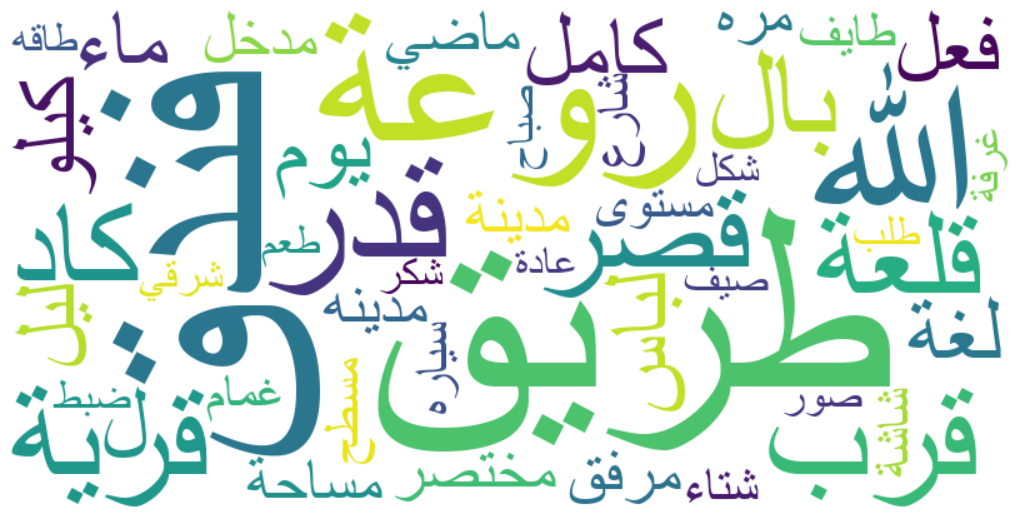


Total number of reviews: 10000
Number of English reviews: 2390
Number of Arabic reviews: 7610


In [7]:
full_stop_words = set(stopwords.words('english') + stopwords_list())
# Function to extract themes using NMF
def extract_themes(texts, n_themes=5, n_top_words=10):
    vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
    tfidf = vectorizer.fit_transform(texts)
    nmf = NMF(n_components=n_themes, random_state=1).fit(tfidf)
    
    feature_names = vectorizer.get_feature_names_out()
    themes = []
    for topic_idx, topic in enumerate(nmf.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        themes.append(f"Theme {topic_idx + 1}: {', '.join(top_words)}")
    
    return themes, vectorizer, tfidf

# Function to extract common keywords
def extract_keywords(texts, stop_words, n_keywords=50, is_arabic=False):
    vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=stop_words)
    tfidf = vectorizer.fit_transform(texts)
    
    feature_names = vectorizer.get_feature_names_out()
    tfidf_sorting = np.argsort(tfidf.toarray()).flatten()[::-1]
    
    top_keywords = [feature_names[i] for i in tfidf_sorting[:n_keywords]]
    
    if is_arabic:
        stemmer = FarasaStemmer()
        stemmed_keywords = []
        for keyword in top_keywords:
            stemmed_keywords.append(stemmer.stem(keyword))
        return stemmed_keywords
    else:
        return top_keywords

# Function to create  word cloud
def create_word_cloud(keywords, is_arabic=False):

    word_freq = Counter(keywords)
    wc = WordCloud(width=800, height=400, background_color='white', font_path='arial' if is_arabic else None)
    wc.generate_from_frequencies(word_freq)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()
    plt.close()

# Analyze English reviews
print("Analysis of English reviews:")
english_themes, english_vectorizer, english_tfidf = extract_themes(english_df['cleaned_content'])
print("\nThemes in English reviews:")
for theme in english_themes:
    print(theme)

english_keywords = extract_keywords(english_df['cleaned_content'], full_stop_words)
print("\nTop keywords in English reviews:")
print(', '.join(english_keywords[:20]))  # Print top 20 for brevity
create_word_cloud(english_keywords)

# Analyze Arabic reviews
print("\n\nAnalysis of Arabic reviews:")
arabic_themes, arabic_vectorizer, arabic_tfidf = extract_themes(arabic_df['cleaned_content'])
print("\nThemes in Arabic reviews:")
for theme in arabic_themes:
    print(theme)

arabic_keywords = extract_keywords(arabic_df['cleaned_content'], full_stop_words, is_arabic=True)
print("\nTop keywords in Arabic reviews:")
print(', '.join(arabic_keywords[:20]))  # Print top 20 for brevity
create_word_cloud(arabic_keywords, is_arabic=True)


# Print some statistics
print(f"\nTotal number of reviews: {len(df)}")
print(f"Number of English reviews: {len(english_df)}")
print(f"Number of Arabic reviews: {len(arabic_df)}")

# 3. **Exploratory Data Analysis (EDA)**


This section provides a comprehensive overview of the exploratory data analysis conducted on the dataset. The following visualizations have been generated to better understand the distribution and relationships between various features in the dataset:

### Analyze the distribution of sentiments, offerings, destinations, and ratings.
1. **Distribution of Sentiments**:
   - A pie chart showcasing the proportion of different sentiment categories in the dataset.
   - Helps to visualize the overall sentiment distribution.

2. **Distribution of Offerings**:
   - A bar chart representing the frequency of various offerings.
   - Highlights the most common offerings in the dataset.

3. **Distribution of Destinations**:
   - A bar chart illustrating the frequency of different destinations.
   - Provides insights into the most popular destinations.

4. **Distribution of Normalized User Ratings**:
   - A bar chart showing the distribution of normalized user ratings.
   - Helps to understand the overall user rating trends.


#### 1. Distribution of Sentiments

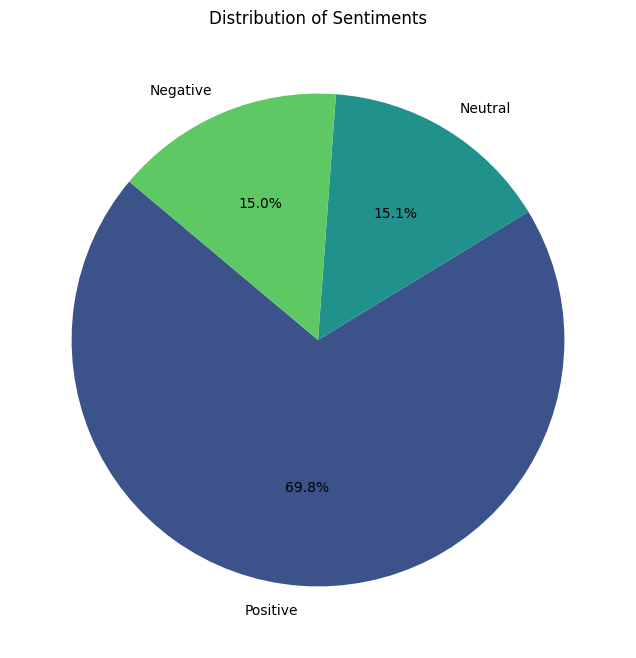

In [8]:
sentiment_counts = df['sentiment'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("viridis", len(sentiment_counts)))
plt.title('Distribution of Sentiments')
plt.show()

The majority of sentiments are positive (69.8%), followed by nearly equal proportions of neutral (15.1%) and negative (15.0%) sentiments.

#### 2. Distribution of Offerings

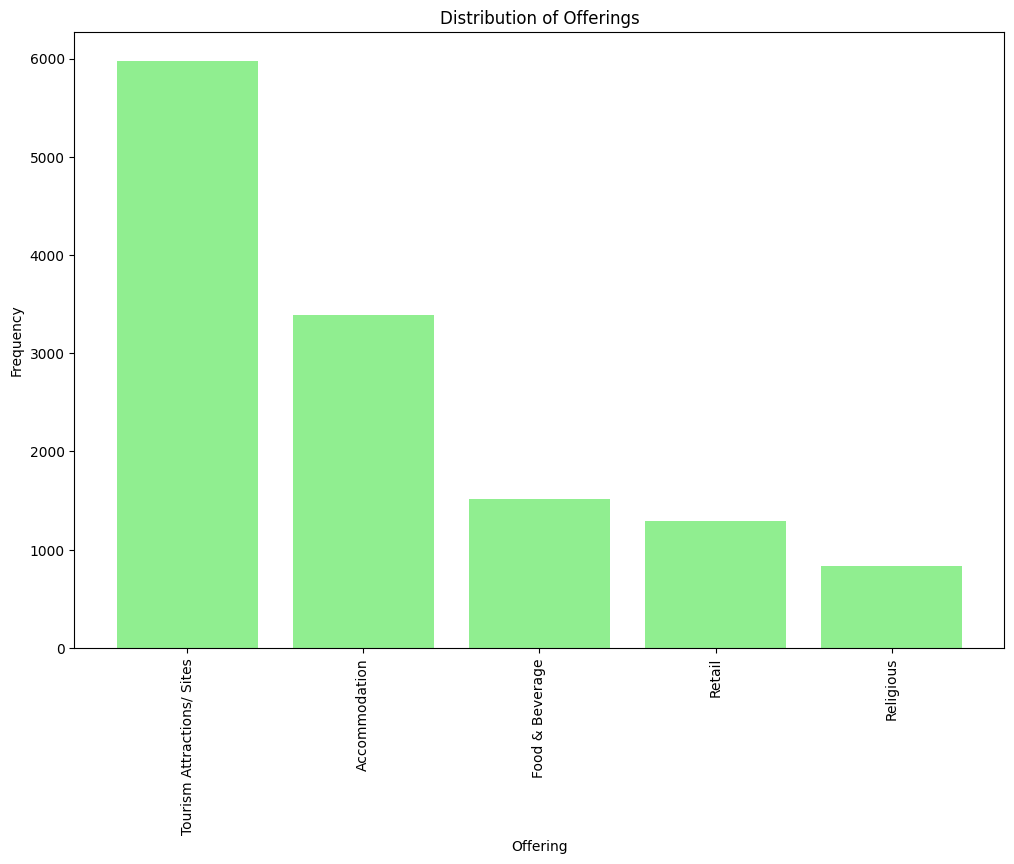

In [9]:
# Extracting and counting offerings
offerings_list = df['offerings'].sum()
offerings_counter = Counter(offerings_list)

# Creating a DataFrame for offerings distribution
offerings_df = pd.DataFrame(offerings_counter.items(), columns=['Offering', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Plotting the distribution of offerings
plt.figure(figsize=(12, 8))
plt.bar(offerings_df['Offering'], offerings_df['Frequency'], color='lightgreen')
plt.title('Distribution of Offerings')
plt.xlabel('Offering')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()


Tourism attractions and sites are the most common offerings, significantly outnumbering other categories like accommodation, food & beverage, retail, and religious offerings.

#### 3. Distribution of Destinations

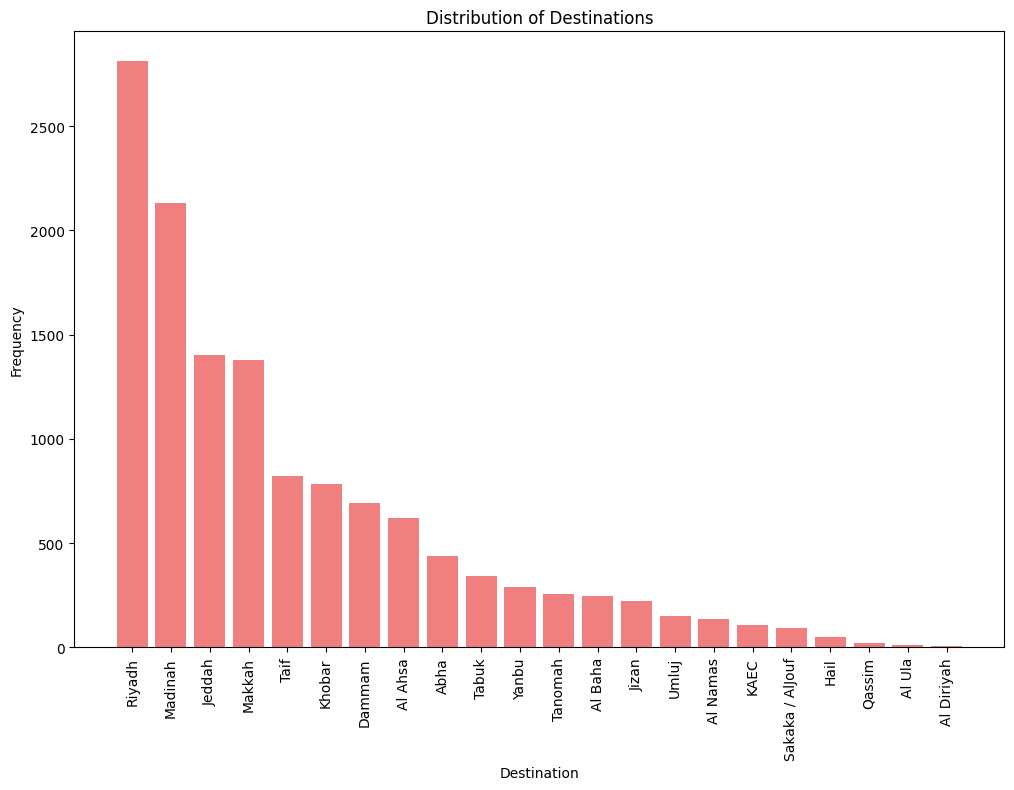

In [10]:
# Extracting and counting destinations
destinations_list = df['destinations'].sum()
destinations_counter = Counter(destinations_list)

# Creating a DataFrame for destinations distribution
destinations_df = pd.DataFrame(destinations_counter.items(), columns=['Destination', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Plotting the distribution of destinations
plt.figure(figsize=(12, 8))
plt.bar(destinations_df['Destination'], destinations_df['Frequency'], color='lightcoral')
plt.title('Distribution of Destinations')
plt.xlabel('Destination')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

Riyadh and Madinah are the top destinations, with Riyadh leading by a considerable margin, followed by Madinah, Jeddah, and Makkah.

#### 4. Distribution of Normalized User Ratings

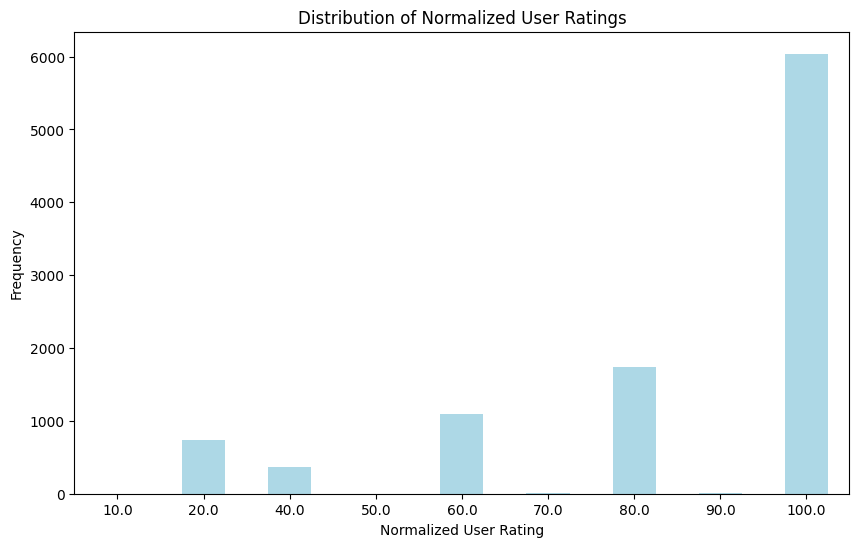

In [11]:
# Analyzing the distribution of norm_user_rating
norm_user_rating_distribution = df['norm_user_rating'].value_counts().sort_index()

# Plotting the distribution of norm_user_rating
plt.figure(figsize=(10, 6))
norm_user_rating_distribution.plot(kind='bar', color='lightblue')
plt.title('Distribution of Normalized User Ratings')
plt.xlabel('Normalized User Rating')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()


User ratings are highly polarized with a peak at the highest rating (100), indicating a large number of highly satisfied users.

### Investigate patterns or correlations between different variables (e.g., relation between sentiment and ratings).

1. **Offerings Comparison Between Top Destinations**:
   - A bar chart comparing the frequency of offerings among the top 5 destinations.
   - Useful for analyzing the diversity of offerings across popular destinations.

2. **Average Norm User Ratings Comparison Between Top Destinations**:
   - A bar chart depicting the average normalized user ratings for different offerings at the top destinations.
   - Highlights the user satisfaction levels for various offerings across key destinations.

3. **Mean Norm User Ratings Across Different Destinations**:
   - A bar chart displaying the mean normalized user ratings for each destination.
   - Provides an overall view of user satisfaction across all destinations.

4. **Comparison of Categorized Ratings and Sentiments (Normalized)**:
   - A heatmap comparing the distribution of categorized ratings (positive, neutral, negative) with sentiments.
   - Normalized values to show row-wise percentages.

5. **Heatmap of Average Norm User Ratings by Destination and Offering**:
   - A heatmap showing the average normalized user ratings for each combination of destination and offering.
   - Helps to identify the best and worst-rated offerings and destinations.

6. **Comparison of Two Approaches to Generate Sentiment Column**:
   - A figure with two heatmaps comparing categorized ratings and sentiments (normalized) for two sentiment generation approaches: LLM approach on the left and pretrained model on the right.


#### 1. Offerings Comparison Between Top Destinations

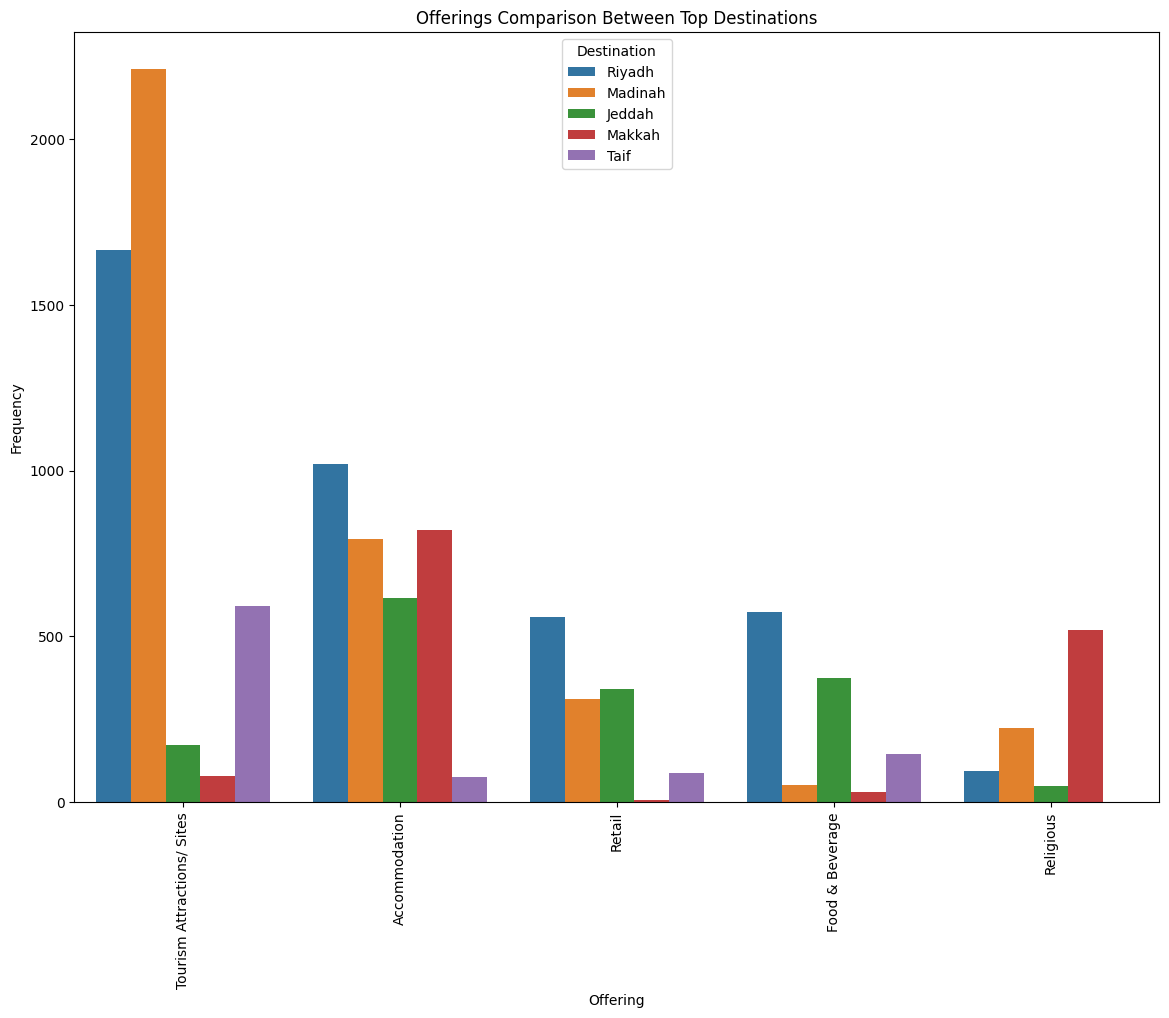

In [12]:
# Extract top destinations
top_destinations = destinations_df.head(5)['Destination'].tolist()

# Filter data for top destinations
filtered_df = df[df['destinations'].apply(lambda x: any(dest in x for dest in top_destinations))]

# Create a function to count offerings for each destination
def count_offerings(destination):
    offerings_counter = Counter()
    for offerings_list, destinations_list in zip(filtered_df['offerings'], filtered_df['destinations']):
        if destination in destinations_list:
            offerings_counter.update(offerings_list)
    return offerings_counter

# Calculate offerings for each top destination
offerings_data = {destination: count_offerings(destination) for destination in top_destinations}

# Convert to DataFrame for visualization
offerings_df_list = []
for destination, counter in offerings_data.items():
    df_temp = pd.DataFrame(counter.items(), columns=['Offering', 'Frequency'])
    df_temp['Destination'] = destination
    offerings_df_list.append(df_temp)
offerings_comparison_df = pd.concat(offerings_df_list)

# Plot the offerings comparison for top destinations
plt.figure(figsize=(14, 10))
sns.barplot(data=offerings_comparison_df, x='Offering', y='Frequency', hue='Destination')
plt.title('Offerings Comparison Between Top Destinations')
plt.xlabel('Offering')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.legend(title='Destination')
plt.show()


Tourism attractions and sites dominate in Riyadh and Madinah, whereas accommodation is more prevalent in Riyadh and Jeddah.

#### 2. Average Norm User Ratings Comparison Between Top Destinations

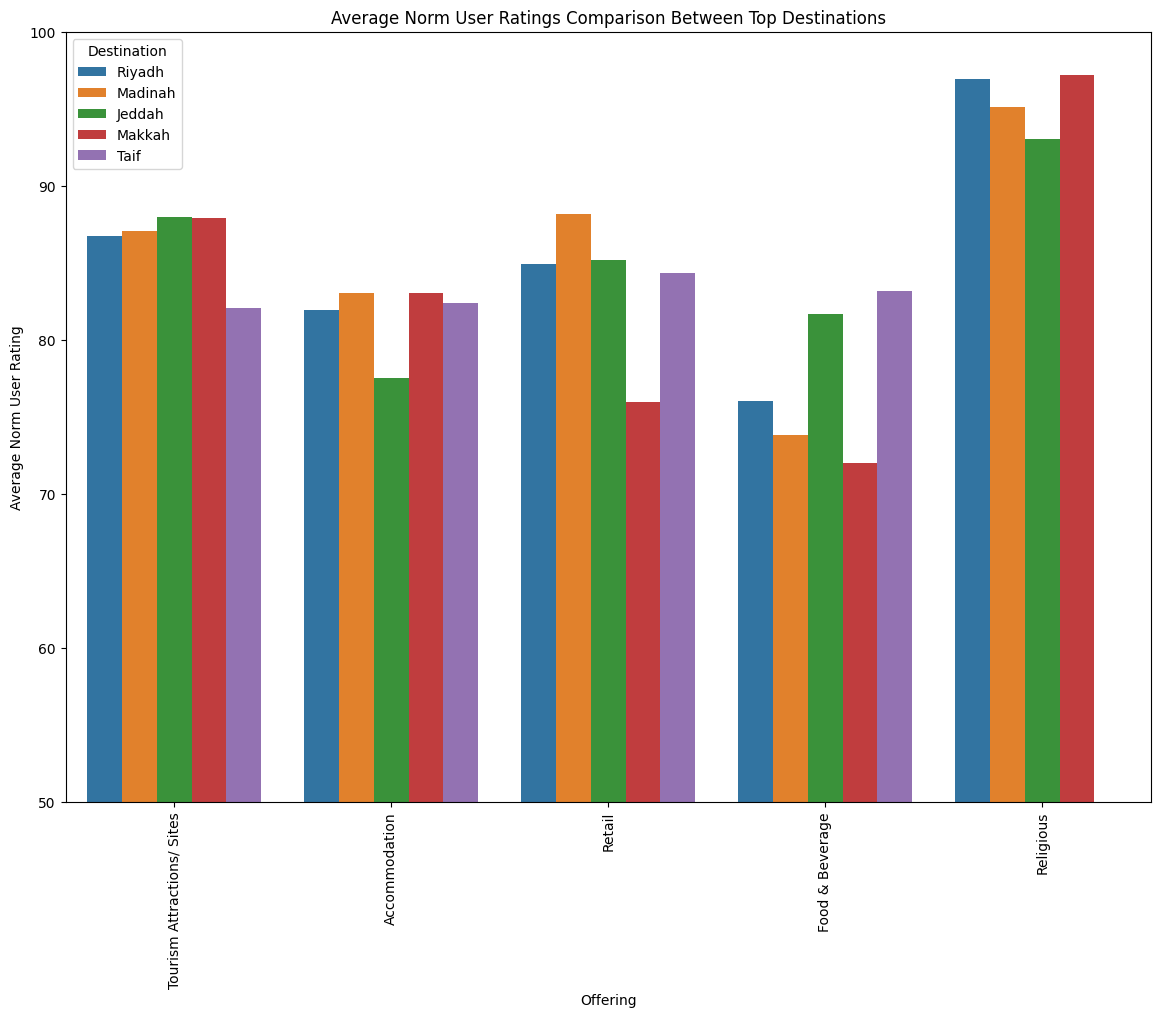

In [13]:
# Create a function to calculate the average norm user rating for each offering at a destination
def average_norm_user_rating(destination):
    offerings_ratings = {}
    for offerings_list, destinations_list, rating in zip(filtered_df['offerings'], filtered_df['destinations'], filtered_df['norm_user_rating']):
        if destination in destinations_list:
            for offering in offerings_list:
                if offering not in offerings_ratings:
                    offerings_ratings[offering] = []
                if not np.isnan(rating): offerings_ratings[offering].append(rating)
    # Calculate average ratings
    average_ratings = {offering: sum(ratings)/len(ratings) for offering, ratings in offerings_ratings.items()}
    return average_ratings

# Calculate average norm user ratings for each top destination
average_ratings_data = {destination: average_norm_user_rating(destination) for destination in top_destinations}

# Convert to DataFrame for visualization
average_ratings_df_list = []
for destination, ratings in average_ratings_data.items():
    df_temp = pd.DataFrame(ratings.items(), columns=['Offering', 'Average Norm User Rating'])
    df_temp['Destination'] = destination
    average_ratings_df_list.append(df_temp)
average_ratings_comparison_df = pd.concat(average_ratings_df_list)

# Plot the average norm user ratings comparison for top destinations
plt.figure(figsize=(14, 10))
sns.barplot(data=average_ratings_comparison_df, x='Offering', y='Average Norm User Rating', hue='Destination')
plt.title('Average Norm User Ratings Comparison Between Top Destinations')
plt.xlabel('Offering')
plt.ylabel('Average Norm User Rating')
plt.xticks(rotation=90)
plt.ylim(50, 100)
plt.legend(title='Destination')

plt.show()


Average user ratings for offerings are generally high across top destinations, indicating overall satisfaction with the offerings.

#### 3. Mean Norm User Ratings Across Different Destinations

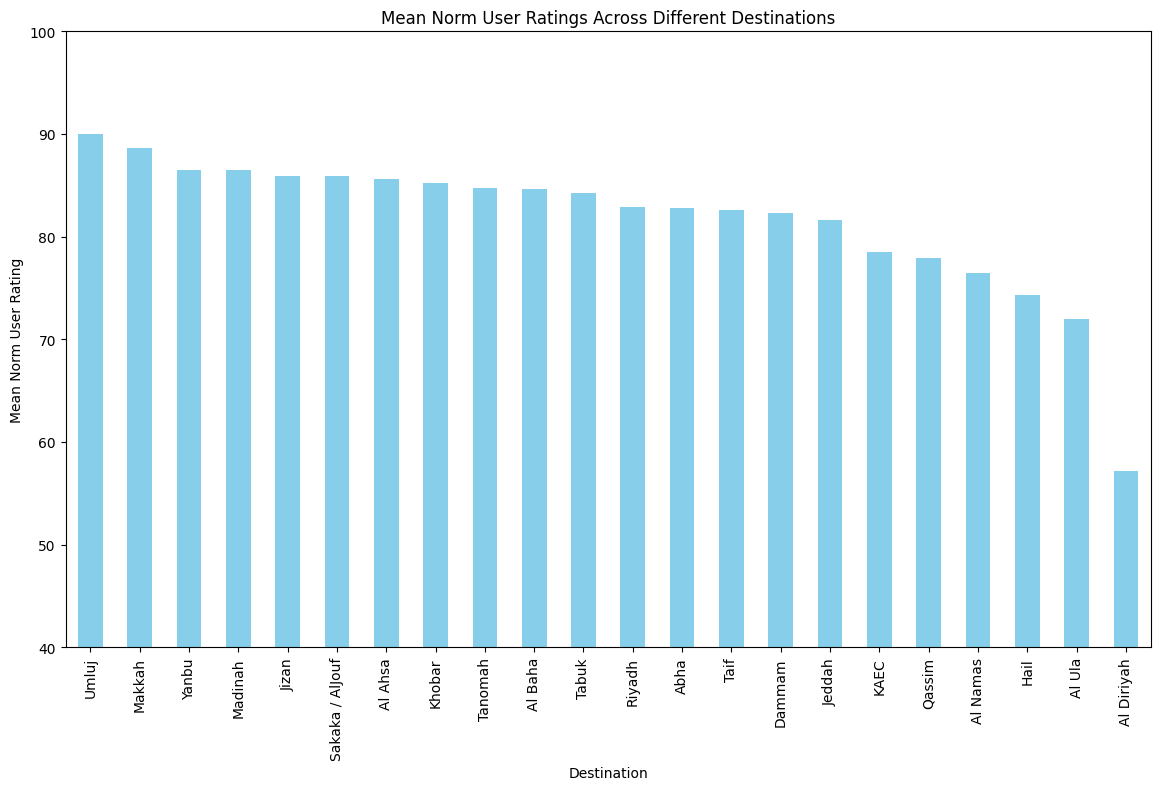

In [14]:
# Calculate mean ratings for each destination
df_exploeded = df.copy()
df_exploeded = df_exploeded.explode('destinations')
mean_ratings = df_exploeded.groupby('destinations')['norm_user_rating'].mean().sort_values(ascending=False)

# Bar plot for mean ratings
plt.figure(figsize=(14, 8))
mean_ratings.plot(kind='bar', color='skyblue')
plt.title('Mean Norm User Ratings Across Different Destinations')
plt.xlabel('Destination')
plt.ylabel('Mean Norm User Rating')
plt.xticks(rotation=90)
plt.ylim(40, 100)
plt.show()

Umluj has the highest mean user rating, while Al Diriyah has the lowest, suggesting variability in user satisfaction across destinations.

#### 4. Comparison of Categorized Ratings and Sentiments (Normalized)

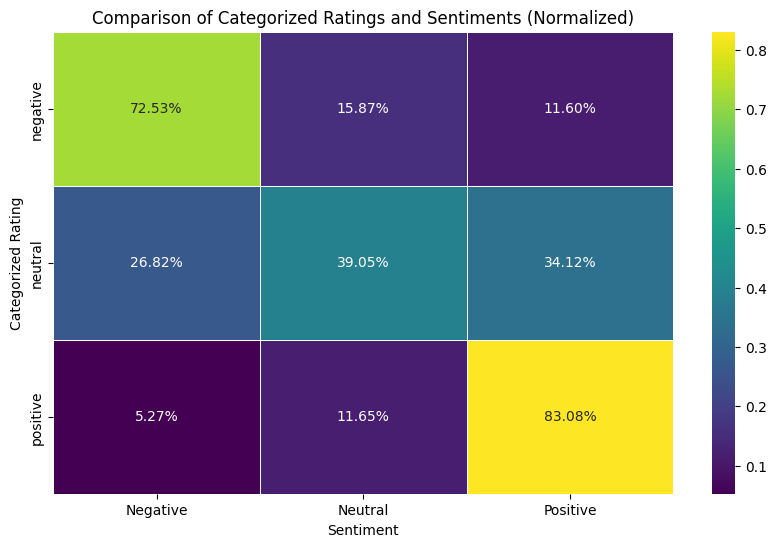

In [15]:
# Define a function to categorize norm_user_rating
def categorize_rating(rating):
    if rating < 50:
        return 'negative'
    elif 50 <= rating < 70:
        return 'neutral'
    else:
        return 'positive'

# Apply the function to create a new column
df['categorized_rating'] = df['norm_user_rating'].apply(categorize_rating)

# Create a crosstab to compare categorized ratings and sentiments
comparison_crosstab = pd.crosstab(df['categorized_rating'], df['sentiment'])

# Normalize the crosstab to get row-wise percentages
comparison_crosstab_normalized = comparison_crosstab.div(comparison_crosstab.sum(axis=1), axis=0) 

# Plot the heatmap with normalized values
plt.figure(figsize=(10, 6))
sns.heatmap(comparison_crosstab_normalized, annot=True, cmap='viridis', fmt='.2%', linewidths=.5)
plt.title('Comparison of Categorized Ratings and Sentiments (Normalized)')
plt.xlabel('Sentiment')
plt.ylabel('Categorized Rating')
plt.show()

Positive ratings correspond strongly with positive sentiments (83.08%), while negative ratings are predominantly associated with negative sentiments (72.53%).

#### 5. Heatmap of Average Norm User Ratings by Destination and Offering

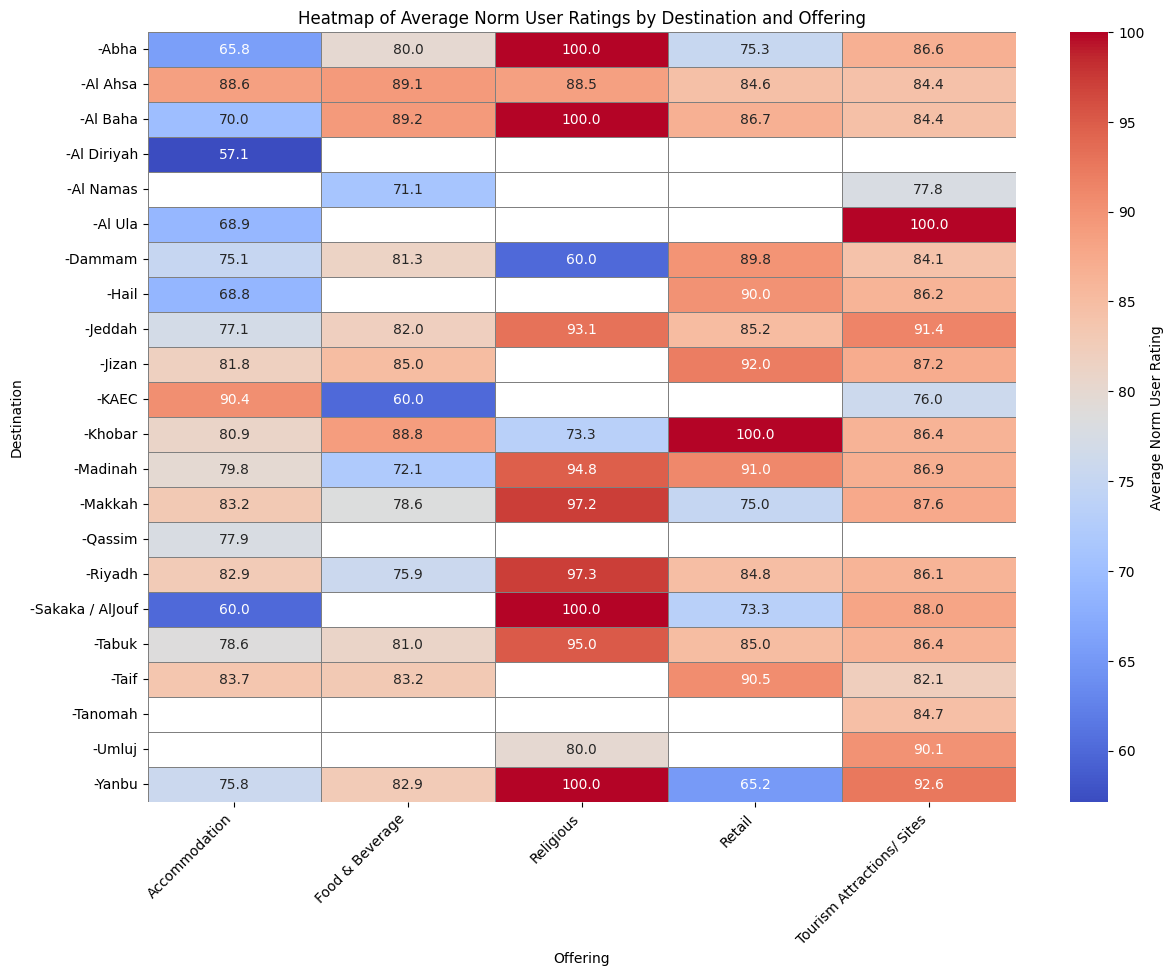

In [16]:
data = df.copy()
# Extract the necessary columns for the heatmap
offerings = data['offerings']
destinations = data['destinations']
ratings = data['norm_user_rating']

# Create a DataFrame for offerings, destinations, and ratings
exploded_data = pd.DataFrame({
    'offerings': offerings.explode(),
    'destinations': destinations.explode(),
    'ratings': ratings
})

# Group by offerings and destinations to get average ratings
heatmap_data = exploded_data.groupby(['offerings', 'destinations']).mean().unstack().fillna(0)

plt.figure(figsize=(14, 10))

# Creating a mask for zero values
mask = heatmap_data.T == 0

# Plotting the heatmap
sns.heatmap(heatmap_data.T, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={'label': 'Average Norm User Rating'}, mask=mask, linewidths=.5, linecolor='grey')
plt.title('Heatmap of Average Norm User Ratings by Destination and Offering')
plt.xlabel('Offering')
plt.ylabel('Destination')
plt.xticks(rotation=45, ha='right')
plt.yticks(ticks=plt.yticks()[0], labels=[label.get_text().replace('ratings', '') for label in plt.yticks()[1]], rotation=0)
plt.show()

Religious offerings and tourism attractions generally receive high average ratings, especially in locations like Riyadh, Makkah, and Al Ahsa. However, some areas like Sakaka / AlJouf show lower ratings for specific offerings.

***Note***: Empty cells indicate that no offerings in that destination have been reviewed.

#### 6. Comparison of Two Approaches to Generate Sentiment Column

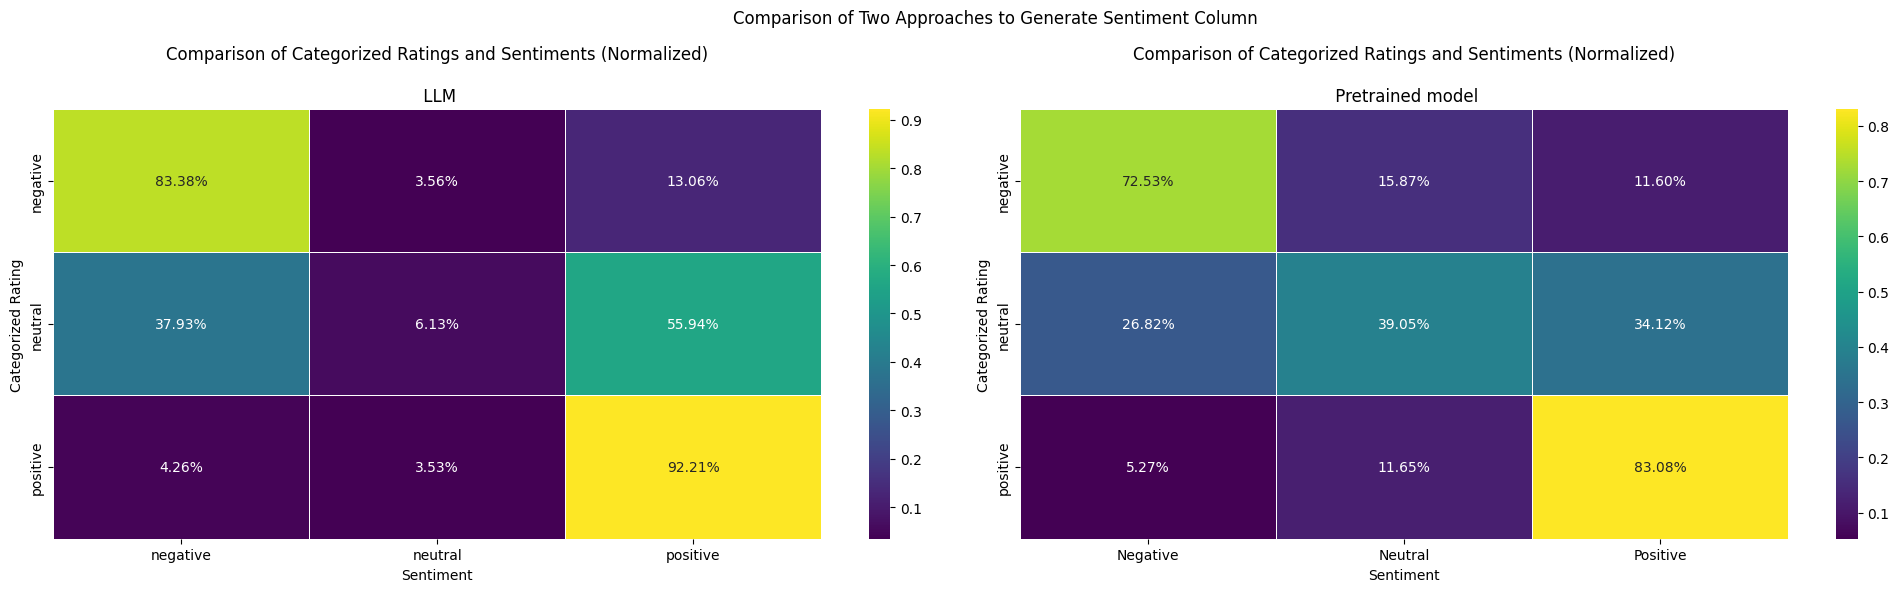

In [17]:
llm = pd.read_csv("dataset_with_sentiment_LLM.csv")


# Apply the function to create a new column
llm['categorized_rating'] = llm['norm_user_rating'].apply(categorize_rating)

# Create a crosstab to compare categorized ratings and sentiments
comparison_crosstab_llm = pd.crosstab(llm['categorized_rating'], llm['sentiment'])

# Normalize the crosstab to get row-wise percentages
comparison_crosstab_normalized_llm = comparison_crosstab_llm.div(comparison_crosstab_llm.sum(axis=1), axis=0) 

# Plot the heatmap with normalized values
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
fig.suptitle('Comparison of Two Approaches to Generate Sentiment Column')

sns.heatmap(comparison_crosstab_normalized_llm, annot=True, cmap='viridis', fmt='.2%', linewidths=.5, ax=axes[0])
axes[0].set_title('Comparison of Categorized Ratings and Sentiments (Normalized)\n\n LLM')
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Categorized Rating')

# Plot the second heatmap on the second subplot
sns.heatmap(comparison_crosstab_normalized, annot=True, cmap='viridis', fmt='.2%', linewidths=.5, ax=axes[1])
axes[1].set_title('Comparison of Categorized Ratings and Sentiments (Normalized)\n\n Pretrained model')
axes[1].set_xlabel('Sentiment')
axes[1].set_ylabel('Categorized Rating')

# Show the plot
plt.tight_layout()
plt.show()

The comparison shows that the LLM model aligns more closely with positive and negative customer ratings, while the pre-trained model has a higher correlation with neutral ratings.

## Future work:

- Deeper comparison between the two methods of generating sentiment column.
- More advanced analysis for Arabic and English text.
- More advanced categories and themes extraction.
- Further analysis of the findings of the EDA.
- Further analysis depicting the demographic breakdown (age, gender, location) of reviewers for more targeted marketing strategies.